+ ### Generate VAE encodings for hourly data

In [3]:
from trainer_VAE import VAETrainer
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


def encode_hourly_data(latent_dim=64, num_hidden_layers=2):
    model_dir = f'./vae_model/latent_dim_{latent_dim}_layers_{num_hidden_layers}/'
    model_file_pref = f'model_'
    vae = VAETrainer.load_model(model_dir, model_file_pref)
    vae.summary()

    scaler = StandardScaler()
    train_data = np.load('./datasets/hourly_train.npy')
    scaler.fit(train_data)

    data = scaler.transform(train_data)
    n_data = len(data) // 24 - 1
    encode = np.zeros((24, n_data, vae.latent_dim))
    for i in range(0, len(data) - 24 - 1):
        day_data = data[i:i+24]
        encode[i % 24][i // 24] = vae.encode(day_data)
    print('data shape : ', data.shape)
    print('encoded shape : ', encode.shape)
    np.save('./datasets/encoded_train.npy', encode)

    test_data = np.load('./datasets/hourly_test.npy')
    data = scaler.transform(test_data)
    n_data = len(data) // 24
    encode = np.zeros((n_data, vae.latent_dim))
    for i in range(0, len(data), 24):
        day_data = data[i:i+24]
        encode[i//24] = vae.encode(day_data)
    print('data shape : ', data.shape)
    print('encoded shape : ', encode.shape)
    np.save('./datasets/encoded_test.npy', encode)

encode_hourly_data(latent_dim=64, num_hidden_layers=2)


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 24, 12)]     0                                            
__________________________________________________________________________________________________
enc_conv_0 (Conv1D)             (None, 12, 512)      18944       encoder_input[0][0]              
__________________________________________________________________________________________________
enc_conv_1 (Conv1D)             (None, 6, 512)       786944      enc_conv_0[0][0]                 
__________________________________________________________________________________________________
enc_flatten (Flatten)           (None, 3072)         0           enc_conv_1[0][0]                 
____________________________________________________________________________________________

+ ### Compare VAE-only reconstructed hourly data with original

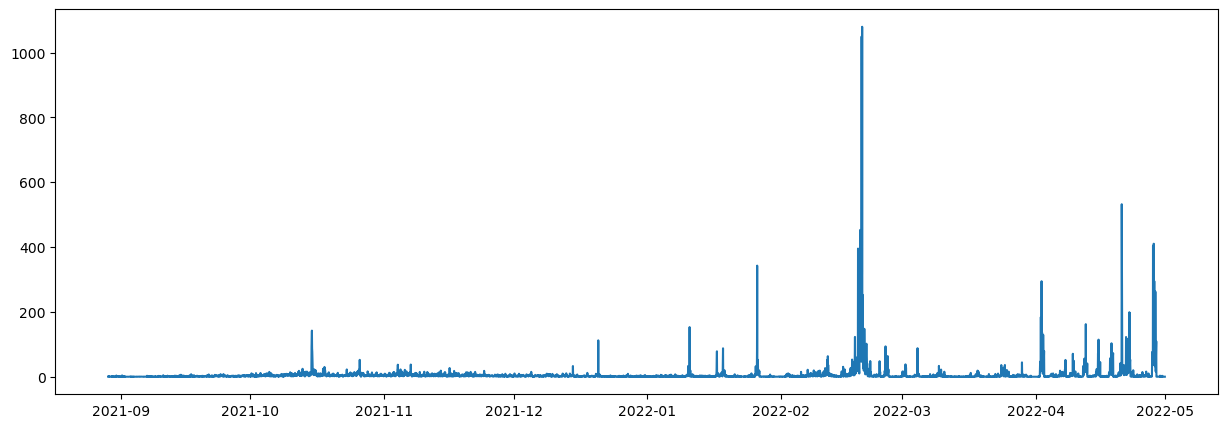

In [4]:
orig = np.load('./datasets/hourly_test.npy')
encoded = np.load('./datasets/encoded_test.npy')
model = VAETrainer.load_model('./vae_model/latent_dim_64_layers_2/', 'model_')

decoded = model.decoder(encoded)
decoded = decoded.numpy().reshape(-1, 12)

scaler = StandardScaler()
scaler.fit(orig)
orig = scaler.transform(orig)

vae_loss = np.mean(np.square(np.subtract(orig, decoded)), axis=1)
np.save('vae_loss.npy', vae_loss)

x = pd.date_range('2021-08-29 0:00', periods=5880, freq='H').to_pydatetime().tolist()

df_vae = pd.DataFrame({'loss' : vae_loss}, index = x)

plt.figure(figsize=(15,5))
plt.plot(x, vae_loss)
#plt.show()
plt.savefig('vae_loss.png')

+ ### Execute transformer with VAE-encoded input (run main.py)
    ```
    python main.py --mode test
    ```

+ ### Draw transformer reconstruction loss of each sliding window(28 days)

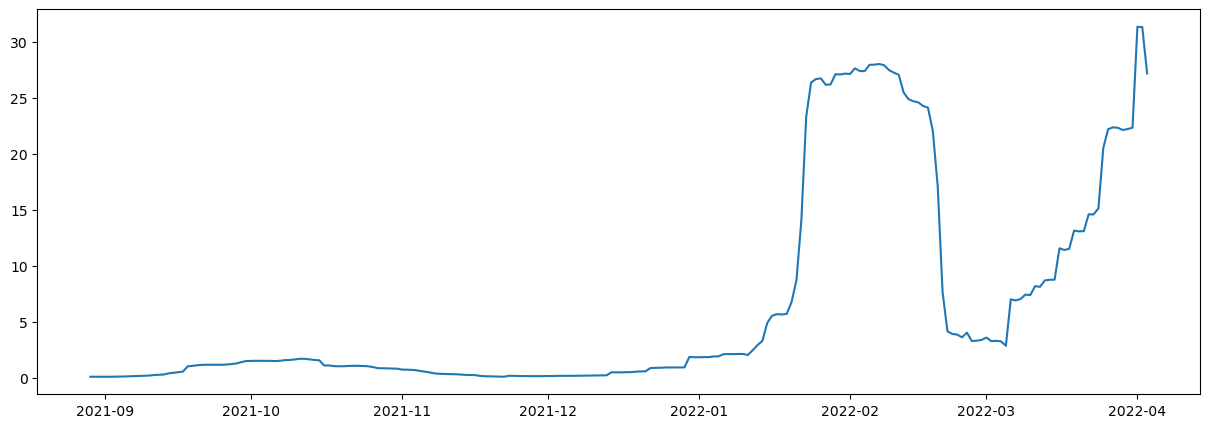

In [5]:
import matplotlib.pyplot as plt
import pandas as pd, numpy as np

tf_loss = np.load('loss_test_data.npy')
window_loss = np.mean(tf_loss, axis=1)
x = pd.date_range('2021-08-29 0:00', periods=218, freq='D').to_pydatetime().tolist()
plt.figure(figsize=(15,5))
plt.plot(x, window_loss)
plt.show()

+ ### Calculate aggregated & averaged transformer loss per each day

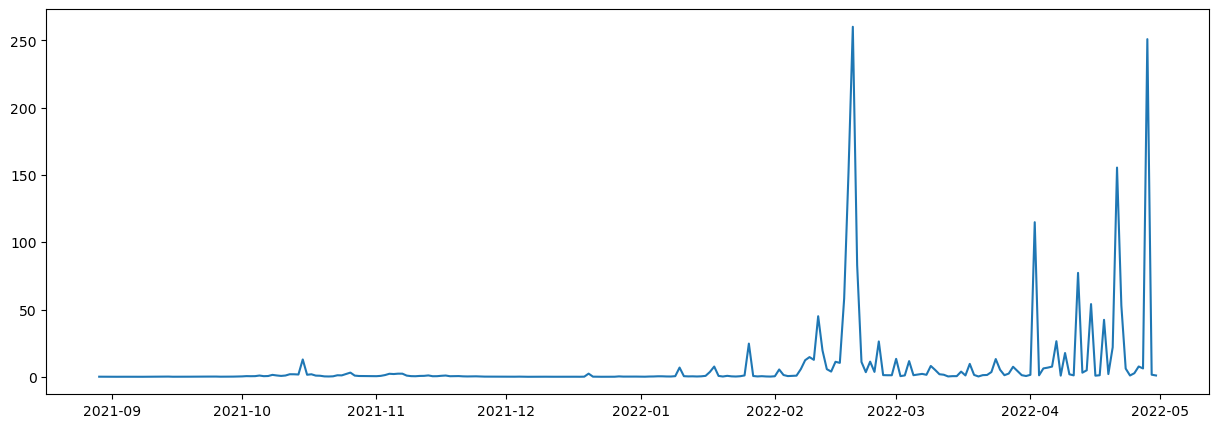

In [6]:
def aggregate_tf_loss_from_sliding_windows(data):

    l = data.shape[1]
    n = data.shape[0]
    ano = np.zeros((n, l+n-1))
    count = np.zeros(l+n-1)

    for i in range(0, n):
        for j in range(0, l):
            ano[i, i+j] = data[i, j]
            count[i + j] += 1

    agg_loss = np.sum(ano, axis=0) / count
    return agg_loss

tf_loss_day = aggregate_tf_loss_from_sliding_windows(tf_loss)
np.save('transformer_loss.npy', tf_loss_day)

x = pd.date_range('2021-08-29 0:00', periods=245, freq='D').to_pydatetime().tolist()
df1 = pd.DataFrame({'loss' : tf_loss_day}, index=x)

plt.figure(figsize=(15,5))
plt.plot(x, tf_loss_day)
#plt.show()
plt.savefig('transformer_loss')

+ ### Reconstruc hourly data from tf decoding output by VAE decoding

In [7]:
tf_recon = np.load('tf_output.npy')
tf_recon = np.reshape(tf_recon, (-1, 64))
vae_recon = model.decoder(tf_recon)
vae_recon = vae_recon.numpy()
vae_recon = np.reshape(vae_recon, (-1, 28, 24, 12))

+ ### Compute anomaly score per each hour

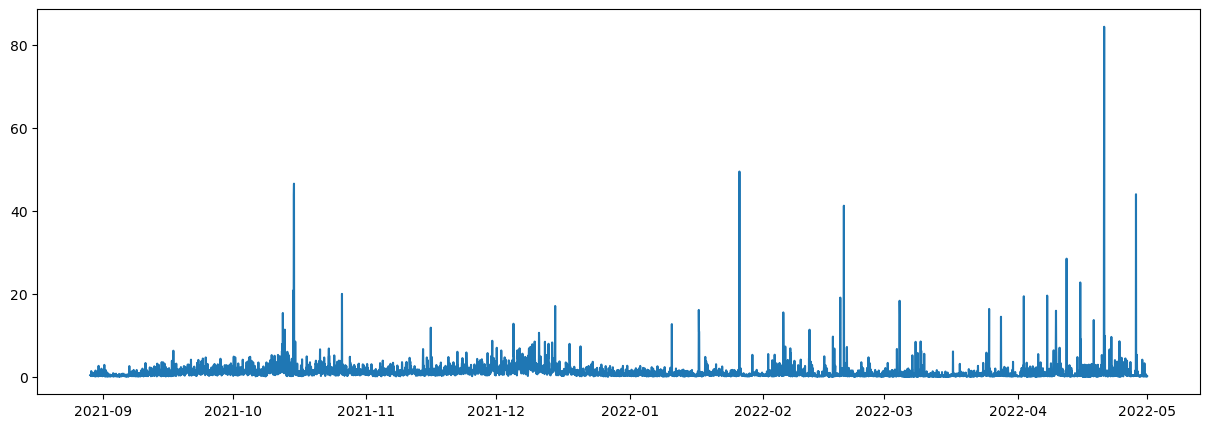

In [8]:
def aggregate_anomaly_score_from_sliding_windows(orig, target):

    l = target.shape[1]
    n = target.shape[0]
    ano = np.zeros((n, l+n-1, 24))
    count = np.zeros((l+n-1))

    for i in range(0, n):
        for j in range(0, l):
            for k in range(0, 24):
                diff = np.subtract(target[i, j, k], orig[(i+j)*24 + k])
                diff = np.square(diff).mean()
                ano[i, i+j, k] = diff
            count[i + j] += 1

    agg = np.sum(ano, axis=0)
    score = np.zeros((n+l-1, 24))
    for i in range(0, n+l-1):
        for j in range(0, 24):
            score[i, j] = agg[i, j] / count[i]
    return score.reshape(-1)

anomaly_score = aggregate_anomaly_score_from_sliding_windows(orig, vae_recon)
np.save('anomaly_score', anomaly_score)

x = pd.date_range('2021-08-29 0:00', periods=5880, freq='H').to_pydatetime().tolist()
plt.figure(figsize=(15,5))
plt.plot(x, anomaly_score)
#plt.show()
plt.savefig('anomaly_score')
